In [9]:
import pandas as pd
import numpy as np

# Load the event data
events_df = pd.read_csv("/Users/marclambertes/Python/Matches/Men/2024-2025/A-League 2024-2025/Adelaide Utd 1-2 Newcastle.csv")  # change path as needed

type_cols = [col for col in events_df.columns if '/qualifierId' in col]

events_df['endX'] = 0.0
events_df['endY'] = 0.0
for i in range(len(events_df)):
    df1 = events_df.iloc[i:i+1,:]
    j = 0
    for j in range(len(type_cols)):
        col = df1[type_cols[j]].values[0]
        if col == 140:
            endx = df1.loc[:,'qualifier/%i/value' %j].values[0]
            events_df['endX'][i] = endx
        else:
            j +=1
    k = 0
    for k in range(len(type_cols)):
        col = df1[type_cols[k]].values[0]
        if col == 141:
            endy = df1.loc[:,'qualifier/%i/value' %k].values[0]
            events_df['endY'][i] = endy
        else:
            k +=1
# Create mock 'type_name' assuming typeId == 1 is 'Pass'
events_df['type_name'] = events_df['typeId'].map({1: 'Pass'})

# Create 'team_name' as the contestantId (placeholder)
events_df['team_name'] = events_df['contestantId']

# Build timestamps from minute + second
events_df['timestamp'] = events_df['timeMin'] * 60 + events_df['timeSec']

# Rename coordinate columns
events_df = events_df.rename(columns={
    'x': 'start_x',
    'y': 'start_y',
    'endX': 'end_x',  # these were used for pass end locations
    'endY': 'end_y'
})

# Combine into location columns
events_df['location'] = events_df[['start_x', 'start_y']].values.tolist()
events_df['end_location'] = events_df[['end_x', 'end_y']].values.tolist()

# Mock player and recipient names
events_df['player_name'] = events_df['eventId']
events_df['pass_recipient_name'] = events_df['eventId'].shift(-1)  # mock recipient

# Define distance function
def euclidean_distance(p1, p2):
    return np.linalg.norm(np.array(p1) - np.array(p2))

# Detect third man runs
def detect_third_man_runs(events, distance_threshold=10):
    third_man_runs = []
    passes = events[events['type_name'] == 'Pass'].reset_index(drop=True)

    for i in range(len(passes) - 1):
        pass1 = passes.iloc[i]
        pass2 = passes.iloc[i + 1]

        if (pass1['team_name'] == pass2['team_name'] and
            pass1['pass_recipient_name'] == pass2['player_name']):

            A = pass1['player_name']
            B = pass1['pass_recipient_name']
            C = pass2['pass_recipient_name']

            if C not in [A, B] and pd.notna(C):
                A_pass_loc = pass1['location']
                C_receive_loc = pass2['location']
                distance = euclidean_distance(A_pass_loc, C_receive_loc)

                if distance >= distance_threshold:
                    third_man_runs.append({
                        'A': A,
                        'B': B,
                        'C': C,
                        'distance': distance,
                        'team': pass1['team_name'],
                        'start_time': pass1['timestamp'],
                        'end_time': pass2['timestamp'],
                        'index_A': pass1.name,
                        'index_C': pass2.name,
                    })

    return pd.DataFrame(third_man_runs)

# Run the detector
third_man_df = detect_third_man_runs(events_df)

# Output the result
print(third_man_df.head())


/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_41372/2501193174.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_df['endX'][i] = endx
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_41372/2501193174.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_df['endY'][i] = endy


   A     B     C   distance                       team  start_time  end_time  \
0  3   4.0   5.0  30.022158  chu9blh367xs3yumct5tqto2q           0         2   
1  4   5.0   6.0  15.993124  chu9blh367xs3yumct5tqto2q           2         3   
2  6   7.0   8.0  37.401203  chu9blh367xs3yumct5tqto2q           6         9   
3  7   8.0   3.0  15.980613  chu9blh367xs3yumct5tqto2q           9        10   
4  9  10.0  11.0  36.923705  chu9blh367xs3yumct5tqto2q          13        15   

   index_A  index_C  
0        0        1  
1        1        2  
2        3        4  
3        4        5  
4        6        7  


In [17]:
import pandas as pd
import numpy as np

# Load the event data
events_df = pd.read_csv("/Users/marclambertes/Python/Matches/Men/2024-2025/A-League 2024-2025/Adelaide Utd 1-2 Newcastle.csv")

# Extract all qualifierId columns
type_cols = [col for col in events_df.columns if '/qualifierId' in col]

# Extract endX (qualifier 140) and endY (qualifier 141)
events_df['endX'] = 0.0
events_df['endY'] = 0.0
for i in range(len(events_df)):
    df1 = events_df.iloc[i:i+1, :]
    for j in range(len(type_cols)):
        if df1[type_cols[j]].values[0] == 140:
            events_df.at[i, 'endX'] = df1[f'qualifier/{j}/value'].values[0]
        if df1[type_cols[j]].values[0] == 141:
            events_df.at[i, 'endY'] = df1[f'qualifier/{j}/value'].values[0]

# Label passes
events_df['type_name'] = events_df['typeId'].map({1: 'Pass'})

# Create team and timestamp fields
events_df['team_name'] = events_df['contestantId']
events_df['timestamp'] = events_df['timeMin'] * 60 + events_df['timeSec']

# Rename coordinate columns
events_df = events_df.rename(columns={
    'x': 'start_x',
    'y': 'start_y',
    'endX': 'end_x',
    'endY': 'end_y'
})

# Combine locations
events_df['location'] = events_df[['start_x', 'start_y']].values.tolist()
events_df['end_location'] = events_df[['end_x', 'end_y']].values.tolist()

# Mock player and recipient names using eventId
events_df['player_name'] = events_df['playerName']
events_df['pass_recipient_name'] = events_df['playerName'].shift(-1)


# Distance function
def euclidean_distance(p1, p2):
    return np.linalg.norm(np.array(p1) - np.array(p2))

# Detect third man runs
def detect_third_man_runs(events, distance_threshold=10):
    third_man_runs = []
    passes = events[events['type_name'] == 'Pass'].reset_index(drop=True)

    for i in range(len(passes) - 1):
        pass1 = passes.iloc[i]
        pass2 = passes.iloc[i + 1]

        if (pass1['team_name'] == pass2['team_name'] and
            pass1['pass_recipient_name'] == pass2['player_name']):

            A = pass1['player_name']
            B = pass1['pass_recipient_name']
            C = pass2['pass_recipient_name']

            if C not in [A, B] and pd.notna(C):
                A_pass_loc = pass1['location']
                C_receive_loc = pass2['location']
                distance = euclidean_distance(A_pass_loc, C_receive_loc)
                time_diff = pass2['timestamp'] - pass1['timestamp']
                speed = distance / time_diff if time_diff > 0 else 0

                if distance >= distance_threshold:
                    third_man_runs.append({
                        'A': A,
                        'B': B,
                        'C': C,
                        'distance': distance,
                        'speed': speed,
                        'team': pass1['team_name'],
                        'start_time': pass1['timestamp'],
                        'end_time': pass2['timestamp'],
                        'index_A': pass1.name,
                        'index_C': pass2.name,
                    })

    return pd.DataFrame(third_man_runs)

# Score third man runs
def add_value_score(third_man_df, events_df):
    if third_man_df.empty:
        third_man_df['value_score'] = []
        third_man_df['value_score_normalized'] = []
        return third_man_df

    max_distance = third_man_df['distance'].max()

    scores = []
    for _, row in third_man_df.iterrows():
        try:
            a_x = events_df.loc[row['index_A'], 'start_x']
            c_x = events_df.loc[row['index_C'], 'start_x']
            distance = row['distance']
            time_diff = row['end_time'] - row['start_time']
            speed = row['speed']

            # Normalize distance
            norm_distance = distance / max_distance if max_distance > 0 else 0
            # Vertical gain toward goal (assuming left-to-right)
            vertical_gain = max((c_x - a_x) / 105, 0)
            # Normalize speed (cap at 10 m/s for safety)
            norm_speed = min(speed / 10, 1)

            value_score = round((0.5 * norm_distance) + (0.3 * vertical_gain) + (0.2 * norm_speed), 3)
            scores.append(value_score)
        except:
            scores.append(0)

    third_man_df['value_score'] = scores

    # Normalize score to 0-1
    min_score = third_man_df['value_score'].min()
    max_score = third_man_df['value_score'].max()
    third_man_df['value_score_normalized'] = (
        (third_man_df['value_score'] - min_score) / (max_score - min_score)
        if max_score != min_score else third_man_df['value_score']
    ).round(3)

    return third_man_df

# Run detection and scoring
third_man_df = detect_third_man_runs(events_df)
third_man_df = add_value_score(third_man_df, events_df)

# Show result
print(third_man_df[['A', 'B', 'C', 'distance', 'speed', 'value_score', 'value_score_normalized']].head())


             A            B            C   distance      speed  value_score  \
0      L. Rose     M. Natta    K. Grozos  30.022158  15.011079        0.361   
1     M. Natta    K. Grozos   L. Bayliss  15.993124  15.993124        0.286   
2   L. Bayliss  T. Aquilina  K. Mizunuma  37.401203  12.467068        0.544   
3  T. Aquilina  K. Mizunuma   E. Alagich  15.980613  15.980613        0.286   
4   C. Timmins     E. Adams      L. Rose  36.923705  18.461853        0.405   

   value_score_normalized  
0                   0.440  
1                   0.326  
2                   0.720  
3                   0.326  
4                   0.508  


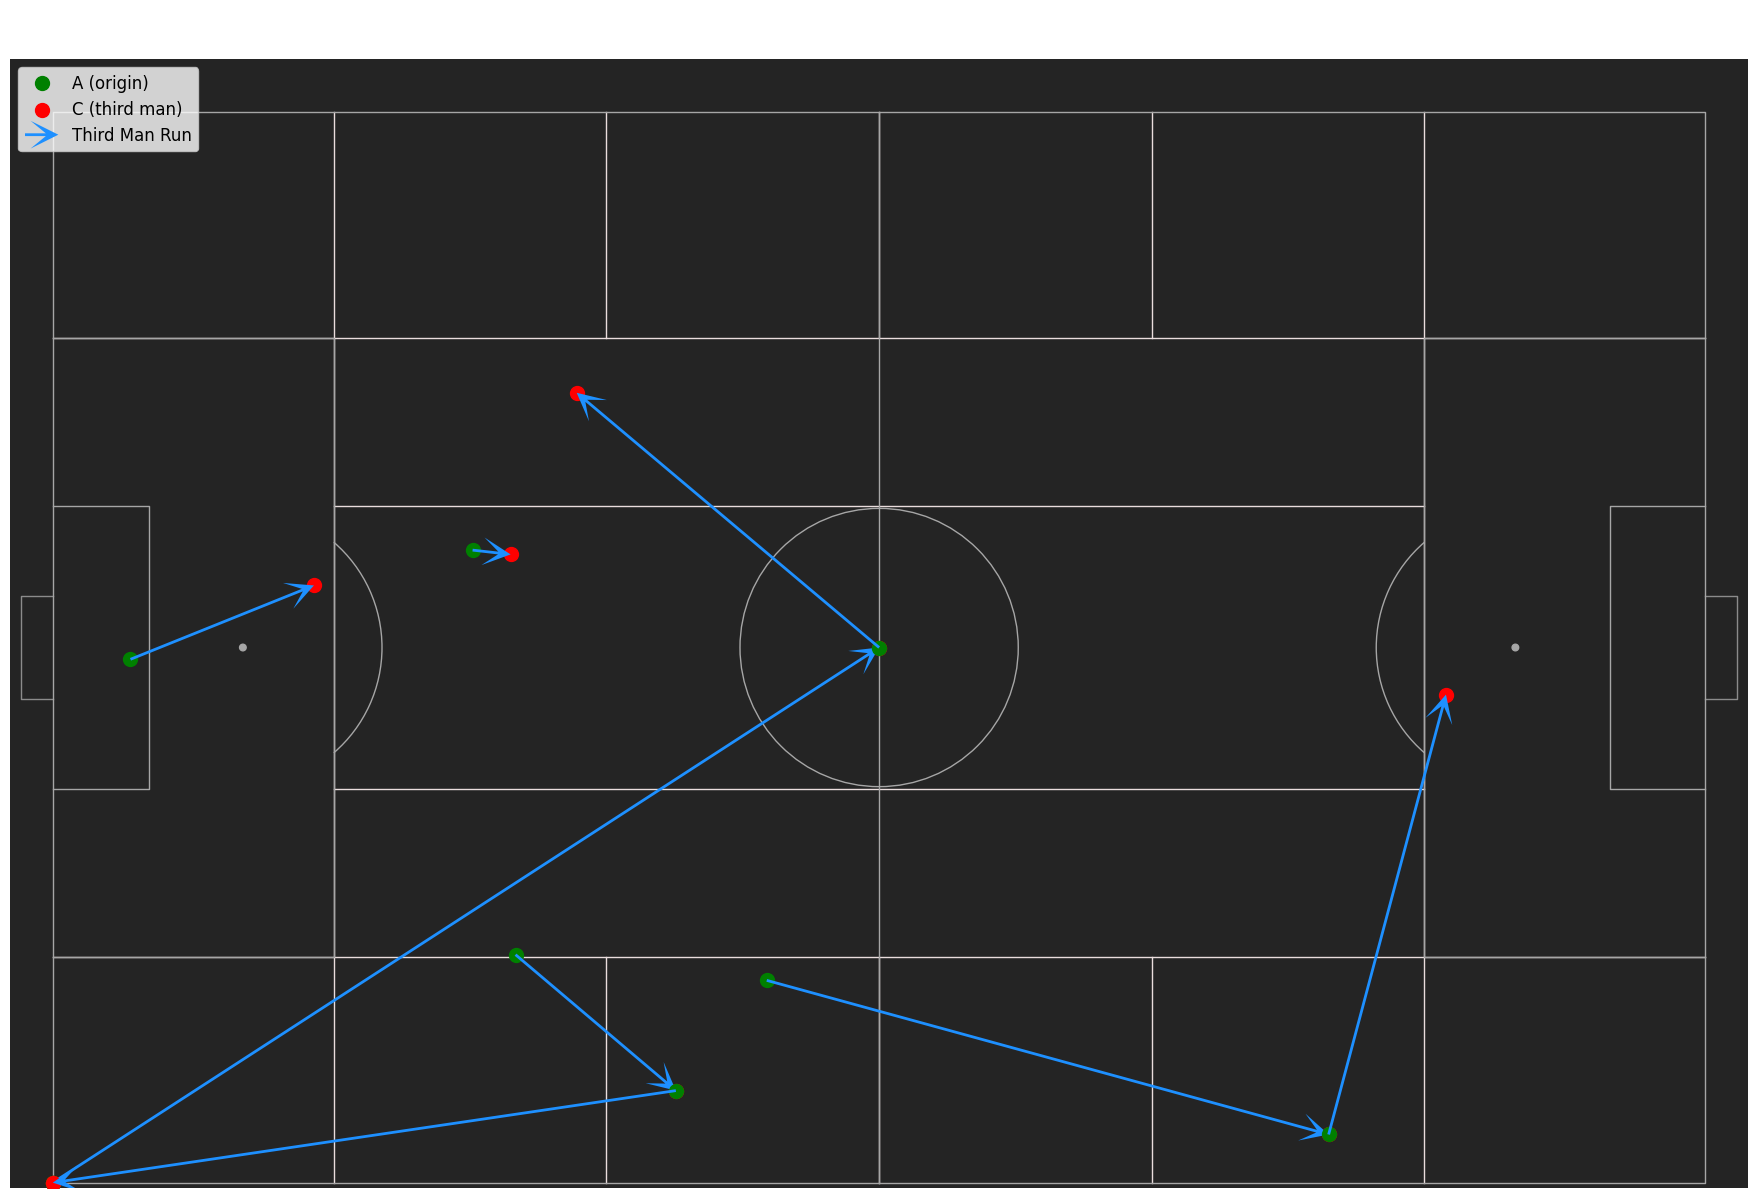

In [18]:
from mplsoccer import Pitch
import matplotlib.pyplot as plt

# Set up pitch
pitch = Pitch(
    positional=True,
    pitch_type='opta',
    pad_bottom=0.5,
    pad_top=5,
    pitch_color='#242424',
    line_color='#a6a6a6',
    linewidth=1,
    half=False,
    goal_type='box',
    goal_alpha=0.8
)

fig, ax = pitch.draw(figsize=(18, 12))

# Plot a few third man runs
for i, row in third_man_df.head(10).iterrows():
    try:
        a_x = events_df.loc[row['index_A'], 'start_x']
        a_y = events_df.loc[row['index_A'], 'start_y']
        c_x = events_df.loc[row['index_C'], 'start_x']
        c_y = events_df.loc[row['index_C'], 'start_y']

        # Plot A's origin (green dot)
        pitch.scatter(a_x, a_y, ax=ax, color='green', s=100, label='A (origin)' if i == 0 else "")

        # Plot C's reception (red dot)
        pitch.scatter(c_x, c_y, ax=ax, color='red', s=100, label='C (third man)' if i == 0 else "")

        # Arrow from A to C (third man movement)
        pitch.arrows(
            a_x, a_y, c_x, c_y,
            ax=ax,
            color='dodgerblue',
            width=2,
            headwidth=10,
            headlength=10,
            linestyle='--',
            label='Third Man Run' if i == 0 else ""
        )
    except:
        continue

# Add legend
ax.legend(loc='upper left', fontsize=12)
plt.title('Third Man Runs — Visualised on Pitch', fontsize=20, color='white', pad=20)
plt.show()


In [24]:
import pandas as pd
import numpy as np

# --- Load and Preprocess Event Data ---
events_df = pd.read_csv("/Users/marclambertes/Python/Matches/Men/2024-2025/A-League 2024-2025/Adelaide Utd 1-2 Newcastle.csv")

# Extract endX and endY from qualifiers
type_cols = [col for col in events_df.columns if '/qualifierId' in col]
events_df['endX'] = 0.0
events_df['endY'] = 0.0
for i in range(len(events_df)):
    for j in range(len(type_cols)):
        qid = events_df.iloc[i][type_cols[j]]
        if qid == 140:
            events_df.at[i, 'endX'] = events_df.iloc[i][f'qualifier/{j}/value']
        elif qid == 141:
            events_df.at[i, 'endY'] = events_df.iloc[i][f'qualifier/{j}/value']
            

# Add pitch-related, time, and player info
events_df['type_name'] = events_df['typeId'].map({1: 'Pass'})
events_df['type_name'] = events_df['type_name'].fillna(
    events_df['typeId'].apply(lambda x: 'Shot' if x in [13, 14, 15, 16] else None)
)

events_df['team_name'] = events_df['contestantId']
events_df['timestamp'] = events_df['timeMin'] * 60 + events_df['timeSec']
events_df = events_df.rename(columns={'x': 'start_x', 'y': 'start_y'})
events_df['location'] = events_df[['start_x', 'start_y']].values.tolist()
events_df['end_location'] = events_df[['endX', 'endY']].values.tolist()
events_df['player_name'] = events_df['playerName']
events_df['pass_recipient_name'] = events_df['playerName'].shift(-1)

# --- Detection Function ---
def euclidean_distance(p1, p2):
    return np.linalg.norm(np.array(p1) - np.array(p2))

def detect_third_man_runs(events, distance_threshold=10):
    third_man_runs = []
    passes = events[events['type_name'] == 'Pass'].reset_index(drop=False)

    for i in range(len(passes) - 1):
        pass1 = passes.iloc[i]
        pass2 = passes.iloc[i + 1]

        if pass1['team_name'] == pass2['team_name'] and pass1['pass_recipient_name'] == pass2['player_name']:
            A = pass1['player_name']
            B = pass1['pass_recipient_name']
            C = pass2['pass_recipient_name']

            if C not in [A, B] and pd.notna(C):
                A_loc = pass1['location']
                C_loc = pass2['location']
                distance = euclidean_distance(A_loc, C_loc)
                time_diff = pass2['timestamp'] - pass1['timestamp']
                speed = distance / time_diff if time_diff > 0 else 0

                third_man_runs.append({
                    'A': A, 'B': B, 'C': C,
                    'team': pass1['team_name'],
                    'distance': distance,
                    'speed': speed,
                    'run_time': time_diff,
                    'index_A': pass1['index'],
                    'index_C': pass2['index']
                })

    return pd.DataFrame(third_man_runs)

# --- Value Score Calculation ---
def add_value_score(third_man_df, events_df):
    if third_man_df.empty:
        third_man_df['value_score'] = []
        third_man_df['value_score_normalized'] = []
        return third_man_df

    max_distance = third_man_df['distance'].max()
    scores = []

    for _, row in third_man_df.iterrows():
        try:
            a_x = events_df.loc[row['index_A'], 'start_x']
            c_x = events_df.loc[row['index_C'], 'start_x']
            norm_distance = row['distance'] / max_distance if max_distance else 0
            vertical_gain = max((c_x - a_x) / 105, 0)
            norm_speed = min(row['speed'] / 10, 1)
            score = round((0.5 * norm_distance) + (0.3 * vertical_gain) + (0.2 * norm_speed), 3)
            scores.append(score)
        except:
            scores.append(0)

    third_man_df['value_score'] = scores
    min_score, max_score = min(scores), max(scores)
    third_man_df['value_score_normalized'] = (
        (third_man_df['value_score'] - min_score) / (max_score - min_score)
        if max_score != min_score else third_man_df['value_score']
    ).round(3)

    return third_man_df

# --- Tactical Metrics ---
def analyze_third_man_runs(third_man_df, events_df):
    summary = {}

    # Total runs per team
    summary['runs_per_team'] = third_man_df.groupby('team').size().reset_index(name='third_man_runs')

    # Avg distance
    summary['avg_distance'] = third_man_df['distance'].mean()

    # Final third entries
    third_man_df['c_x'] = third_man_df['index_C'].apply(lambda idx: events_df.loc[idx, 'start_x'])
    third_man_df['in_final_third'] = third_man_df['c_x'] > 70
    summary['final_third_entry_count'] = third_man_df['in_final_third'].sum()
    summary['final_third_entry_pct'] = round(third_man_df['in_final_third'].mean(), 2)

    # Shots within next 2 events
    def leads_to_shot(row):
        idx = row['index_C']
        next_events = events_df.iloc[idx+1:idx+3]
        return 'Shot' in next_events['type_name'].values

    third_man_df['leads_to_shot'] = third_man_df.apply(leads_to_shot, axis=1)
    summary['shots_created'] = third_man_df['leads_to_shot'].sum()

    # Average run time
    summary['avg_run_time'] = third_man_df['run_time'].mean()

    # Left vs Right Bias
    third_man_df['flank'] = third_man_df['index_C'].apply(
        lambda idx: 'Left' if events_df.loc[idx, 'start_y'] < 34 else 'Right'
    )
    summary['flank_bias'] = third_man_df['flank'].value_counts(normalize=True).to_dict()

    # Player role involvement
    roles = pd.concat([
        third_man_df[['A']].rename(columns={'A': 'player'}).assign(role='A'),
        third_man_df[['B']].rename(columns={'B': 'player'}).assign(role='B'),
        third_man_df[['C']].rename(columns={'C': 'player'}).assign(role='C')
    ])
    role_counts = roles.groupby(['player', 'role']).size().unstack(fill_value=0)
    role_counts['total'] = role_counts.sum(axis=1)
    role_counts['role_profile'] = role_counts.apply(
        lambda row: 'Exploiter' if row['C'] > row['A'] + row['B'] else 'Enabler',
        axis=1
    )
    summary['role_profiles'] = role_counts.sort_values(by='total', ascending=False)

    return third_man_df, summary

# --- Run Pipeline ---
third_man_df = detect_third_man_runs(events_df)
third_man_df = add_value_score(third_man_df, events_df)
third_man_df, summary = analyze_third_man_runs(third_man_df, events_df)

# --- Merge per-player roles with team info ---
# Create player-role involvement table
roles = pd.concat([
    third_man_df[['A', 'team']].rename(columns={'A': 'player'}).assign(role='A'),
    third_man_df[['B', 'team']].rename(columns={'B': 'player'}).assign(role='B'),
    third_man_df[['C', 'team']].rename(columns={'C': 'player'}).assign(role='C')
])

# Count role appearances
player_roles = roles.groupby(['player', 'role']).size().unstack(fill_value=0)
player_roles['total'] = player_roles.sum(axis=1)

# Add contestantId (team_name) per player — use most common team per player
player_teams = roles.groupby('player')['team'].agg(lambda x: x.mode().iloc[0])
player_roles['contestantId'] = player_teams

# Optional: Reorder columns
cols = ['contestantId', 'A', 'B', 'C', 'total']
player_roles = player_roles[cols]

# --- Save everything to one Excel sheet ---
with pd.ExcelWriter("third_man_run_summary.xlsx", engine='xlsxwriter') as writer:
    # Third man events
    third_man_df.to_excel(writer, sheet_name='Third_Man_Summary', index=False, startrow=0)

    # Per-player summary — written below it
    start_row = len(third_man_df) + 3
    player_roles.to_excel(writer, sheet_name='Third_Man_Summary', startrow=start_row)
